<a href="https://colab.research.google.com/github/achyut-srivastava/Projects/blob/master/MNIST_PYTORCH_VISULAIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Relevant libraries

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Performing transformations on training and tresting datasets

since we have only one channel i.e the shape of the image is (N, 1, H ,W)

N = No of images

1 = Channel

H, W = Height and width of images

our mean and standard deviation consists of single number of 0.5

In [5]:
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
])
training_datasets = datasets.MNIST('./root', train=True, download=True,transform=transform)
testing_datasets = datasets.MNIST('./root', train=False, transform=transform)

Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


#Splitting datasets:

split_ratio = amount of data you want as your validation data

Using torch.utils.data.random_split for splitting the data randomly

In [6]:
split_ratio = 0.2
n_valid = int(len(training_datasets)*split_ratio)
n_train = len(training_datasets) - n_valid   
x_train, x_valid = torch.utils.data.random_split(training_datasets, (n_train, n_valid))
len(x_train), len(x_valid)

(48000, 12000)

#Determing batch size and assigning data loader

In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=x_train, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(dataset=x_valid, batch_size=batch_size, shuffle = False)

# Activation gpu or cpu based on avaliability

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visulaizing the split datasets 

Confirming equal splits among the classes in other words the datasets should be a balance class

In [0]:
def bar_graph(loader):
    emp = torch.zeros(10, dtype=torch.int16)     
    for images, labels in valid_loader:
        labels = labels.to(device)
        for l in labels:
            emp[l] += 1
    return emp

In [0]:
num_train = bar_graph(train_loader)
num_valid = bar_graph(valid_loader)

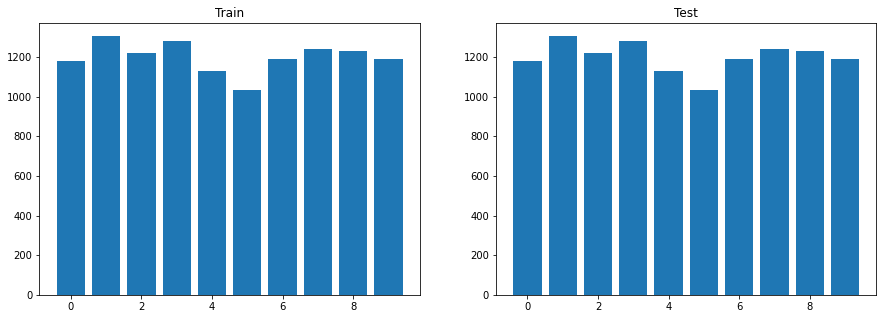

In [21]:
plt.rcParams['figure.figsize'] = [15,5]
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True)
ax1.bar(range(10), num_train)
ax1.set_title('Train')
ax2.bar(range(10), num_valid)
ax2.set_title('Test')
plt.show()

# Creating a model 

In [0]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1),
            nn.LeakyReLU(negative_slope=0.01 ,inplace=True),
            nn.MaxPool2d(2),            
            nn.Conv2d(16, 32, 3, 1),
            nn.LeakyReLU(negative_slope=0.01 ,inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.LeakyReLU(negative_slope=0.01 ,inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Linear(3*3*64, 500),
            nn.LeakyReLU(negative_slope=0.01 ,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(500, 128),
            nn.LeakyReLU(negative_slope=0.01 ,inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128,10),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 3*3*64)
        x = self.classifier(x)
        return x

In [10]:
model = Model().to(device)
model

Model(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=500, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

# Visualizing sample images

In [0]:
def img_converter(images):
  image = images.clone().detach().numpy() 
  image = image.transpose(1,2,0).squeeze()
  return image

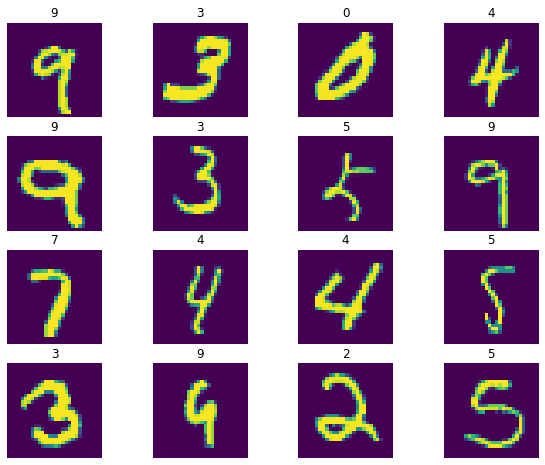

In [18]:
images, labels = next(iter(train_loader))
fig = plt.figure(figsize = (10, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(img_converter(images[i]))
    ax.set_title(labels[i].item())
    plt.axis('off')

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training the model

In [27]:
epochs = 10

train_loss=[]
valid_loss=[]

train_acc=[]
valid_acc=[]

for e in range(epochs):
    tl = 0
    vl = 0
    ta = 0
    va = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        train_pred = model(images)
        loss = criterion(train_pred, labels)
        loss.backward()
        optimizer.step()
        
        tl += loss
        _, train_label = torch.max(train_pred, 1)
        ta += torch.sum(train_label == labels)
    
    with torch.no_grad(): 
        for val_images, val_labels in valid_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)


            val_pred = model(val_images)
            loss = criterion(val_pred, val_labels)

            vl += loss
            _, val_label = torch.max(val_pred, 1)
            va += torch.sum(val_label == val_labels) 
    
    train_loss.append(tl/len(x_train))
    train_acc.append(ta.float()/len(x_train))
    valid_loss.append(vl/len(x_valid))
    valid_acc.append(va.float()/len(x_valid))
    
    print(f"Epochs: {e+1} loss: {tl/len(x_train)} accuracy: {ta.float()/len(x_train)} val_loss: {vl/len(x_valid)} val_acc: {va.float()/len(x_valid)}")

Epochs: 1 loss: 0.0027307462878525257 accuracy: 0.9110833406448364 val_loss: 0.0008318998734466732 val_acc: 0.9749999642372131
Epochs: 2 loss: 0.0006850372301414609 accuracy: 0.9794583320617676 val_loss: 0.0005342090735211968 val_acc: 0.984916627407074
Epochs: 3 loss: 0.0004909644485451281 accuracy: 0.984916627407074 val_loss: 0.0005956473178230226 val_acc: 0.9822499752044678
Epochs: 4 loss: 0.0003739404783118516 accuracy: 0.9888333082199097 val_loss: 0.0004117130010854453 val_acc: 0.9873332977294922
Epochs: 5 loss: 0.00031954629230313003 accuracy: 0.9905416369438171 val_loss: 0.0003797867684625089 val_acc: 0.9892500042915344
Epochs: 6 loss: 0.0002579119463916868 accuracy: 0.9918124675750732 val_loss: 0.0005168666248209774 val_acc: 0.9854999780654907
Epochs: 7 loss: 0.00025653018383309245 accuracy: 0.9924166798591614 val_loss: 0.0004559459921438247 val_acc: 0.9887499809265137
Epochs: 8 loss: 0.00019360454462002963 accuracy: 0.9936041831970215 val_loss: 0.00038552211481146514 val_acc: 0

#Loss and accuracy graphs

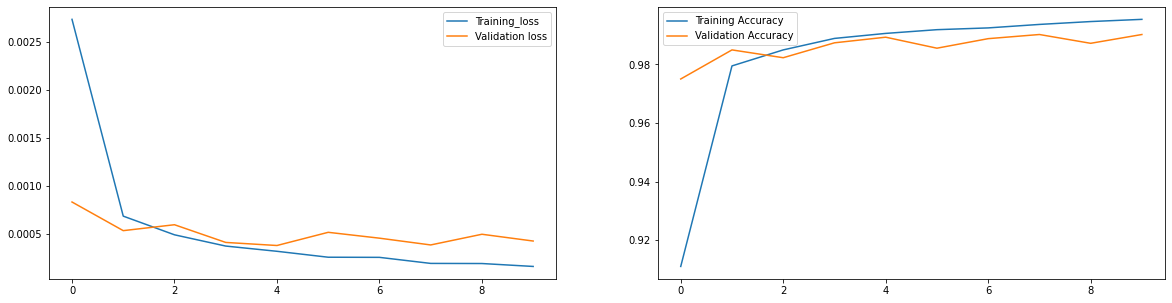

In [28]:
fig = plt.figure(figsize=(20,5))
fig.add_subplot(121)
plt.plot(range(epochs), train_loss, label = 'Training_loss')
plt.plot(range(epochs), valid_loss, label ='Validation loss')
plt.legend()
fig.add_subplot(122)
plt.plot(range(epochs), train_acc, label='Training Accuracy')
plt.plot(range(epochs), valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

#Accuracy for test set

In [14]:
test_loader = torch.utils.data.DataLoader(dataset=testing_datasets, batch_size=batch_size, shuffle = False)
tel = 0
tea = 0
cm_label = []
cm_pred = []
with torch.no_grad(): 
  model.eval()
  for t_images, t_labels in test_loader:
    t_images = t_images.to(device)
    t_labels = t_labels.to(device)

    t_pred = model(t_images)
    loss = criterion(t_pred, t_labels)

    tel += loss
    _, t_label = torch.max(t_pred, 1)
    tea += torch.sum(t_label == t_labels) 

    cm_label.extend(t_labels)
    cm_pred.extend(t_label)
print(f"Testing accuracy: {tea.float()/len(testing_datasets)}  Testing loss:{tel/len(testing_datasets)}")

Testing accuracy: 0.9914000034332275  Testing loss:0.0003289289597887546


In [0]:
torch.save(model.state_dict(), './model_weight.pth')

#plotting confusion matrix useand sklearn and saeborn

In [11]:
model = Model()
model.load_state_dict(torch.load('./model_weight.pth', map_location=device))
model.to(device)

Model(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=500, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [0]:
from sklearn.metrics import confusion_matrix
cm_label = torch.tensor(cm_label)
cm_pred = torch.tensor(cm_pred)
data = confusion_matrix(cm_label, cm_pred)

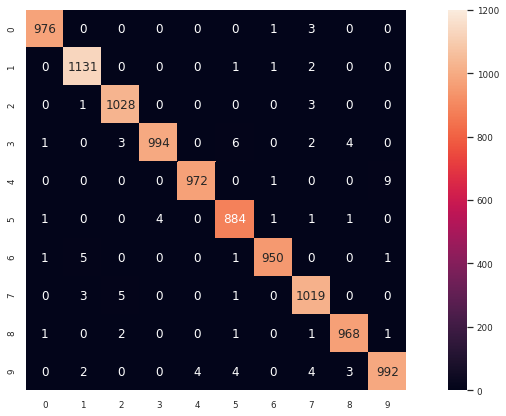

In [34]:
con_mat = pd.DataFrame(data, index = range(10), columns = range(10), dtype=np.int64)
plt.figure(figsize = (15,7))
sns.set(font_scale=0.8)
sns.heatmap(con_mat, annot=True,  annot_kws={"size": 12}, fmt='g', vmax=1200, cbar = True, square= True)
plt.show()

#Visualizing Filters

In [0]:
import matplotlib.gridspec as gridspec
def visualization(model, layer_no):
  kernel = model.features[layer_no].weight
  print(f"Kernel shape: ",kernel.shape)
  image = kernel.cpu().clone().detach().numpy()
  image = torch.tensor(image)
  fig = plt.figure(constrained_layout=False, figsize=(30,30))
  spec = fig.add_gridspec(nrows=image.shape[0], ncols=image.shape[1], left= 0.0, right = 0.3,  wspace=0.05, hspace=0.05)
  counter_inner = 0
  counter_outer = 0
  for out_img in image:
    counter_inner = 0
    for in_img in out_img:
      fig.add_subplot(spec[counter_outer, counter_inner])
      plt.imshow(in_img, cmap='gray')
      plt.axis('off')
      counter_inner += 1
    counter_outer += 1

Kernel shape:  torch.Size([16, 1, 5, 5])


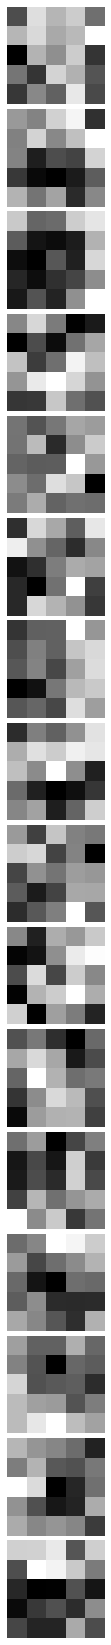

In [36]:
visualization(model, 0)

# Taking a single image from datasets

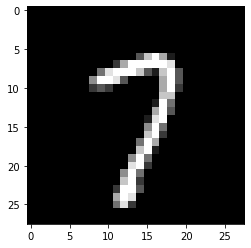

In [38]:
images, labels = next(iter(train_loader))
img1 = images[23]
test_image = img_converter(img1)
plt.imshow(img_converter(img1), cmap='gray')
plt.grid(False)
plt.show()
img1 = img1.unsqueeze(0)
img1 = img1.to(device)

#Hooking a layer in model

In [41]:
test_image.shape

(28, 28)

In [0]:
class get_activation_layer():
  def __init__(self, module, layer_no):
    self.hook = module.features[layer_no].register_forward_hook(self.hook_fn)
    self.layer_num = layer_no
  def hook_fn(self, module, input, output):
    self.layer = self.layer_num
    self.features = output.clone().detach().requires_grad_()
    self.actual_features = output
  def close(self):
    self.hook.remove()

# Visualizing CNN output of the hooked layer

In [0]:
def hook_map_visualization(active_layer):
  image = active_layer.features.clone().detach().cpu().numpy().squeeze()
  im = image.shape[0]
  print(f"Shape at layer {active_layer.layer} is {image.shape}")
  fig = plt.figure(figsize=(10,10))
  sqr = int(np.sqrt(im))
  if sqr%2 != 0:
    sqr +=1
  gs = fig.add_gridspec(nrows = sqr, ncols = sqr, left=0.35, right = 1.1, wspace = 0.0, hspace = 0.0 )
  c_in = 0
  c_out = 0
  for out_img in image:
      if c_in == sqr:
        c_out += 1
        c_in = 0
      fig.add_subplot(gs[c_out, c_in])
      plt.imshow(out_img, cmap = 'gray')      
      plt.grid('off')
      plt.axis('off')
      c_in += 1

# Visualizing mean activation of each filters

In [0]:
def mean_act_visualization(mean_active):
  mean_plot = []
  no_filter = mean_active.actual_features.shape[1]
  for i in range(no_filter):
    mean_plot.append(mean_active.actual_features[0][i].mean())
  plt.bar(range(1,no_filter+1), torch.tensor(mean_plot), color="orange")
  plt.xticks(range(1,no_filter+1))
  plt.grid(False)  
  plt.yticks([])
  plt.title("Layer :"+str(mean_active.layer)+ str(" ")+str(mean_active.actual_features.shape))
  plt.show()
  _, max_mean = torch.max(torch.tensor(mean_plot).unsqueeze(0), 1)
  return max_mean.item()

# Using layer number to acces a prticular layer in model

Passing the single image taken above in the model

In [0]:
layer = 1
activations = get_activation_layer(model, layer)
out = model(img1)

In [72]:
activations.features.shape

torch.Size([1, 16, 24, 24])

Shape at layer 1 is (16, 24, 24)


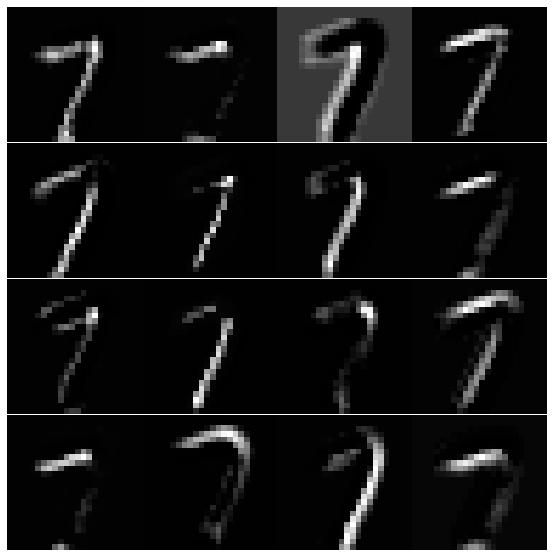

In [73]:
hook_map_visualization(activations)

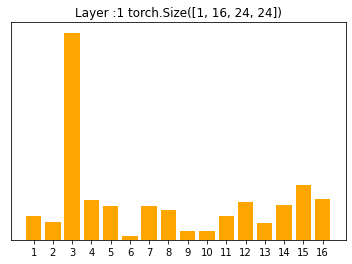

In [74]:
filter_no = mean_act_visualization(activations)

In [75]:
p= activations.features[0 , filter_no]
p.shape, p.mean()

(torch.Size([24, 24]), tensor(0.5701, grad_fn=<MeanBackward0>))

# Maximizing the activation of the max activation filter 

In [76]:
i = p.cpu().clone().detach().numpy()
type(i), i.mean()

(numpy.ndarray, 0.5700566)

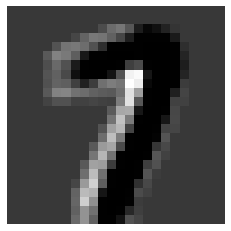

In [77]:
plt.imshow(i, cmap = 'gray')
plt.axis(False)
plt.show()

In [0]:
def denorm(im):
  try:
    imgs = im.cpu().clone().detach().numpy().squeeze()
  except:
    imgs = im
  imgs = imgs.clip(0,1)
  return imgs

def tfms(image):
  _transform = transforms.Compose([ 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,),(0.5,)),

  ])
  imag = _transform(image)
  plt.imshow(denorm(imag))
  imag = imag.unsqueeze(0)
  imag = imag.to(device)
  imag.requires_grad_()
  return imag

In [0]:
class FilterVisual():
  def __init__(self, mod, size = 56, upscaling_step = 12, upscaling_factor = 1.2):
    self.size = size
    self.upscaling_step = upscaling_step
    self.upscaling_factor = upscaling_factor
    self.mymodel = mod
    self.mymodel.eval()
    
  def visualizer(self, layer, n_step, filter_pos, lr):
    sz = self.size
    img = np.float32(np.random.uniform(180, 200, (sz, sz))/255.)
    active_org = get_activation_layer(model, layer)
    for _ in range(self.upscaling_step):
      img_var = tfms(img)
      optimizer = torch.optim.Adam([img_var], lr = lr, weight_decay=1e-6)
      for n in range(n_step):
        optimizer.zero_grad()
        _ =self.mymodel(img_var)
        loss = -1 * (active_org.actual_features[0, filter_pos].mean())
        #print(loss)
        loss.backward()
        optimizer.step()
      print(loss)
      img = denorm(img_var[0])
      sz = int(self.upscaling_factor * sz)
      img = cv2.resize(img, (sz, sz) , interpolation=cv2.INTER_CUBIC)
    plt.imshow(img, cmap = 'gray')
    plt.grid('off')
    plt.axis('off')
    plt.show()  


tensor(-18.2470, grad_fn=<MulBackward0>)
tensor(-17.4033, grad_fn=<MulBackward0>)
tensor(-15.2062, grad_fn=<MulBackward0>)
tensor(-13.4816, grad_fn=<MulBackward0>)
tensor(-11.7630, grad_fn=<MulBackward0>)
tensor(-9.5826, grad_fn=<MulBackward0>)
tensor(-6.3239, grad_fn=<MulBackward0>)
tensor(-3.3397, grad_fn=<MulBackward0>)


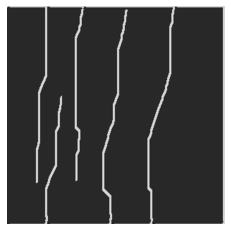

In [104]:
import cv2
model_mod = model.features
SIZE = 30
Up_Stp = 8
Up_Fact = 1.4
F = FilterVisual(model_mod, SIZE, Up_Stp, Up_Fact)

LAYER = layer
LR = 0.1
N_STEP = 200
F.visualizer(LAYER,N_STEP,filter_no,LR)